# Finite difference wave acoustic propagation

Simulação que irá demonstrar a propagação de uma onda acústica em dois meios com velocidades diferentes. Neste caso, teremos que analisar as leis que regem as reflexões e refrações de ondas em meios acústicos. Este código é fortemente inspirado no livro [Computational Seismology: A practical introduction](https://global.oup.com/academic/product/computational-seismology-9780198717416?cc=de&lang=en&).

## Importando bibliotecas

Importando as bibliotecas que serão utilizadas para manipulação e visualização dos dados.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

### Parâmetros para a inicialização da simulação

In [2]:
nx = 200      # grid points in x
nz = 200      # grid points in z
nt = 1000     # number of time steps
h = 10.0     # grid increment in x
dt = 0.001    # Time step
c0 = 3000.0   # velocity (can be an array)
isx = 100     # source index x
isz = 2      # source index z
ist = 100     # shifting of source time function
f0 = 100.0    # dominant frequency of source (Hz)
isnap = 10     # snapshot frequency
T = 1.0 / f0  # dominant period
nop = 5       # length of operator

### Solução da equação de onda e critério de Courant

<IPython.core.display.Javascript object>


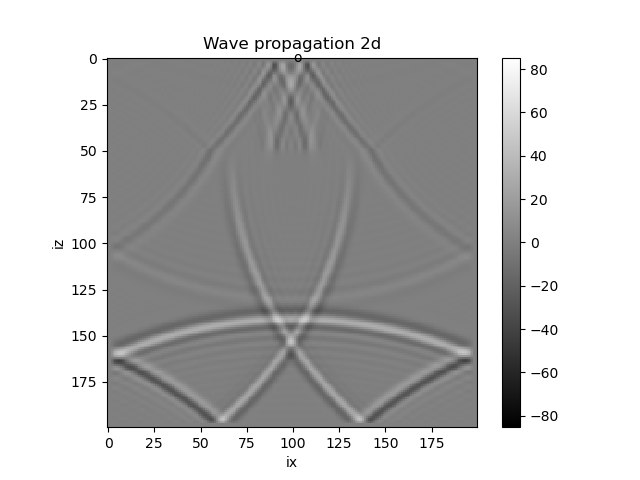

Courant Criterion eps :
0.3


In [3]:
model_type = "heterogeneous_1"

# Initialize pressure at different time steps and the second
# derivatives in each direction
p = np.zeros((nz, nx))
pold = np.zeros((nz, nx))
pnew = np.zeros((nz, nx))
pxx = np.zeros((nz, nx))
pzz = np.zeros((nz, nx))

# Initialize velocity model
c = np.zeros((nz, nx))

if model_type == "homogeneous":
    c += c0
elif model_type == "heterogeneous_1":
    c += c0
    c[1:51,:] *= 0.8
elif model_type == "heterogeneous_2":
    c += c0
    c[1:51,:] *= 1.5
else:
    raise NotImplementedError
    
cmax = c.max()

# Source time function Gaussian, nt + 1 as we loose the last one by diff
src = np.empty(nt + 1)
for it in range(nt):
    src[it] = np.exp(-1.0 / T ** 2 * ((it - ist) * dt) ** 2)
# Take the first derivative
src = np.diff(src) / dt
src[nt - 1] = 0

v = max([np.abs(src.min()), np.abs(src.max())])
# Initialize animated plot
image = plt.imshow(pnew, interpolation='nearest', animated=True,
                   vmin=-v, vmax=+v, cmap='gray')

# Plot the receivers
plt.text(isx, isz, 'o')
plt.colorbar()
plt.xlabel('ix')
plt.ylabel('iz')
plt.ion()
plt.show()

print("Courant Criterion eps :")
print(cmax*dt/h)

# Time extrapolation
for it in range(nt):
    if nop==3:
        # calculate partial derivatives, be careful around the boundaries
        for i in range(1, nx - 1):
            pzz[:, i] = (p[:, i + 1] - 2 * p[:, i] + p[:, i - 1]) / h** 2
        for j in range(1, nz - 1):
            pxx[j, :] = (p[j - 1, :] - 2 * p[j, :] + p[j + 1, :]) / h ** 2

    if nop==5:
        for i in range(2, nx - 2):
            pzz[:, i] = (-p[:, i + 2] + 16. * p[:,i + 1] - 30. * p[:,i] + 16. * p[:,i - 1] - p[:,i - 2])/(12.*(h**2))
        for j in range(2, nz - 2):
            pxx[j,:] = (-p[j + 2, :] + 16. * p[j + 1, :] - 30. * p[j,:] + 16. * p[j - 1, :] - p[j - 2, :])/(12.*(h**2))

    # Time extrapolation
    pnew = 2 * p - pold + dt ** 2 * c ** 2 * (pxx + pzz)
    # Add source term at isx, isz
    pnew[isz, isx] = pnew[isz, isx] + src[it]

    # Plot every isnap-th iteration
    if it % isnap == 0:    # you can change the speed of the plot by increasing the plotting interval
        plt.title('Wave propagation 2d')
        image.set_data(pnew)
        plt.gcf().canvas.draw()

    pold, p = p, pnew      